# Skull Classification Challenge

In this challenge, we are going to create a deep neural network classifier that will work with brain CT scans and discriminate between those which show patients with broken skulls and those that are sane.  

The provided dataset is brain CT scans. Which 1532 shows some form of broken skull (fracture or craniotomy) while the other 7.153 images do not.

The goal would be to get at least 85% sensitivity and 85% specificity. 

The presented approach will be built in pure PyTorch.

In [ ]:
#First let's unzip
!unzip "/content/drive/My Drive/methinks_test/images.zip" -d image_data

Se han truncado las últimas 5000 líneas del flujo de salida.
 extracting: image_data/images_train/4389.png  
 extracting: image_data/images_train/4390.png  
 extracting: image_data/images_train/4391.png  
 extracting: image_data/images_train/4392.png  
 extracting: image_data/images_train/4393.png  
  inflating: image_data/images_train/4394.png  
  inflating: image_data/images_train/4395.png  
  inflating: image_data/images_train/4396.png  
  inflating: image_data/images_train/4397.png  
  inflating: image_data/images_train/4398.png  
  inflating: image_data/images_train/4399.png  
  inflating: image_data/images_train/43.png  
  inflating: image_data/images_train/4400.png  
  inflating: image_data/images_train/4401.png  
  inflating: image_data/images_train/4402.png  
  inflating: image_data/images_train/4403.png  
  inflating: image_data/images_train/4404.png  
 extracting: image_data/images_train/4405.png  
 extracting: image_data/images_train/4406.png  
 extracting: image_data/image

## Overall vision of the dataset

Let's take a look at the dataset.

In [2]:
import numpy as np
from glob import glob
import os 
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch
from torch.utils import data
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("using_cuda: ", use_cuda)

data_dir = os.getcwd() + "/image_data/images_train"

# load filenames 
ct_all_images = np.array(glob(data_dir +"/*"))


# load the csv data
metadata = pd.read_csv( os.getcwd() + '/data.csv')


# print number of images in dataset
print('There are %d total ct images.' % len(ct_all_images))
# get 10 samples of the csv metadata
metadata.sample(10)

using_cuda:  True
There are 8685 total ct images.


,id,broken
1797,2248,0
6824,8563,0
4705,5909,0
3015,3752,0
583,720,1
7255,9093,0
7199,9009,0
259,324,0
5167,6486,0
7507,9417,1


0    7153
1    1532
Name: broken, dtype: int64


Text(0.5, 1.0, 'Patients')

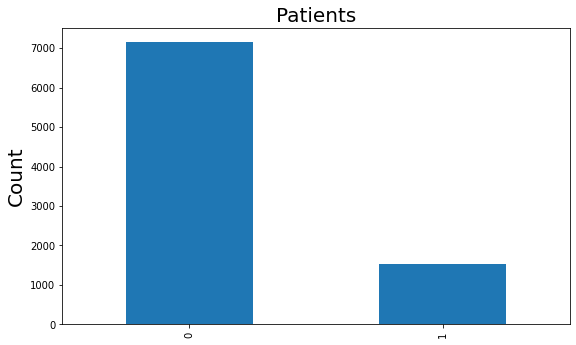

In [3]:

# Getting an idea of how the data is distributed
print(metadata['broken'].value_counts())
fig = plt.figure(figsize=(20,12))

ax1 = fig.add_subplot(222)
metadata['broken'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count', size=20)
ax1.set_title('Patients', size = 20)



## Split the dataset into training, validation and testing


Then, we create a training set and test set.

In [4]:
#Creation of a train ,test and validation set by randomly choosing 20% for test and 10% rows for validation from the dataset
y = metadata['broken']
train_df, test_df= train_test_split(metadata, test_size=0.2, random_state=41, stratify=y)
y = train_df['broken']
train_df, valid_df = train_test_split(train_df, test_size=0.125, random_state=41, stratify=y) # 0.125 x 0.8 = 0.1
print("train shape")
print(train_df.shape)
print("valid shape")
print(valid_df.shape)
print("test shape")
print(test_df.shape)


train shape
(6079, 2)
valid shape
(869, 2)
test shape
(1737, 2)


The training dataset is very skewed and unbalanced, so we augment it to even it out and have a uniform distribution.

In [5]:
train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
test_df = test_df.reset_index()

In [6]:
train_df["id"]

0        8311
1        3515
2        9766
3        5734
4        5857
        ...  
6074     4409
6075     1297
6076     5642
6077    10317
6078      677
Name: id, Length: 6079, dtype: int64

## Define data transforms

Now we are going to build some transform in order to perfom data augmentatiton to prevent overfitting and genertalize better.

In [7]:
from torchvision import datasets
from torchvision import transforms

In [8]:

IMG_SIZE = 224 ##ImageNet dataset size

#Normalize image pixels with the same mean a std ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)) # Let's create a fake RGB image in order to use pretrained models on ImageNet
])

valid_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
])

## Create the dataset objects

Now let's create the datasets. 
We will create a helper class in order to create the dataset. Instead of separating manually the images into class folders, we will take it from the provided ones and separate it based on the metadata "on the fly"

In [9]:
#The class is created in order to build the dataset from a dataframe and obtain the corresponding images
class DatasetCreator(data.Dataset): 
    def __init__(self, df, image_label, y_label, data_dir, img_end, transform=None):
        self.df = df
        self.transform = transform
        self.images_label = image_label
        self.y_label = y_label
        self.data_dir = data_dir
        self.img_end = img_end

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        img_x=self.df[self.images_label][index]
        image = Image.open(os.path.join(data_dir,str(img_x) + self.img_end))
        label= torch.tensor(int(self.df[self.y_label][index])).float()
        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
train_dataset = DatasetCreator(train_df, "id", "broken", data_dir, '.png', transform=train_transform)
valid_dataset = DatasetCreator(valid_df, "id", "broken", data_dir, '.png', transform=valid_transform)
test_dataset = DatasetCreator(test_df, "id", "broken", data_dir, '.png', transform=test_transform)

## Correct the unbalanced dataset.

Create a sampler to correct the unbalanced dataset. In our case we will use a WeightedRandomSampler to subsane the problem

In [11]:
BATCH_SIZE = 64

In [12]:
from torch.utils import data

class_counts = [train_df['broken'].value_counts()[0], train_df['broken'].value_counts()[1]]
num_samples = sum(class_counts)
labels = list(train_df['broken'].values)

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler_train = data.sampler.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


class_counts = [valid_df['broken'].value_counts()[0], valid_df['broken'].value_counts()[1]]
num_samples = sum(class_counts)
labels = list(valid_df['broken'].values)

class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler_valid = data.sampler.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))


[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 

Now we have the dataset, then we can build our DataLoaders.

In [19]:
train_loader = data.DataLoader(train_dataset, batch_size = BATCH_SIZE, sampler = sampler_train)
valid_loader = data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, sampler = sampler_valid)
test_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
loaders_data = {}
loaders_data["train"]=train_loader
loaders_data["valid"]=valid_loader
loaders_data["test"]=test_loader

In order to check that everything seems correct, lets plot some of the resulting images of the training loader.

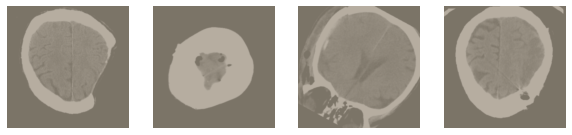

In [20]:
## Lets se some examples of the training loader
import matplotlib.pyplot as plt                        
%matplotlib inline    

data_iter = iter(train_loader)

def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)

Now that we have the data preprocessed, we should select the model. 
After some research, I found that DenseNet seems a good option for medical imaging.

In our case, we will freeze all the weights except for the classification layer and the last feature layer.

The classification layer will be entirely substituted while the last feature layer will only be finetuned.

In [21]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

model_transfer = models.densenet121(pretrained=True)

for name, param in model_transfer.named_parameters():
    if not "features.denseblock4.denselayer16" in name:
        param.requires_grad = False # froze the feature layers except the last layer (denseblock4.denselayer16")
    

input_features_classifier = model_transfer.classifier.in_features
N_CLASSES = 2


classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(input_features_classifier, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 256)),
                          ('relu2', nn.ReLU()),
                          ('drop', nn.Dropout(0.5)),
                          ('fc3', nn.Linear(256, N_CLASSES)),
                          ]))

model_transfer.classifier = classifier
print(model_transfer)
if use_cuda:
    model_transfer = model_transfer.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## The loss function and the optimizer

We will use CrossEntropy loss as we have 2 classes and it is a classification problem.

We will use an Adam optimizer, which is frequently used in that kind of task.

In [22]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
params = list(model_transfer.classifier.parameters()) + list(model_transfer.features.denseblock4.denselayer16.parameters())
optimizer = optim.Adam(params, lr=0.001)

## Define the train function

In [23]:
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 

    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        running_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            optimizer.zero_grad()
            
            output = model(data)
                        
            loss = criterion(output.squeeze(), target.long())
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
        train_loss = running_loss/len(loaders['train'])
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model(data)
            loss = criterion(output.squeeze(), target.long())
            
            valid_loss += loss.item()
            
            
            ## update the average validation loss
        valid_loss = valid_loss/len(loaders["valid"])

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
        ))
        
        ##  save the model if validation loss has decreased
        if valid_loss < valid_loss_min:            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                valid_loss
            ))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

## Train the model.

In [24]:
n_epochs = 30

model_transfer = train(n_epochs, loaders_data, model_transfer, optimizer, criterion, use_cuda, 'model_skull.pt')

Epoch: 1 	Training Loss: 0.478204 	Validation Loss: 0.435182
Validation loss decreased (inf --> 0.435182).  Saving model ...
Epoch: 2 	Training Loss: 0.393101 	Validation Loss: 0.433136
Validation loss decreased (0.435182 --> 0.433136).  Saving model ...
Epoch: 3 	Training Loss: 0.310440 	Validation Loss: 0.370938
Validation loss decreased (0.433136 --> 0.370938).  Saving model ...
Epoch: 4 	Training Loss: 0.307309 	Validation Loss: 0.346050
Validation loss decreased (0.370938 --> 0.346050).  Saving model ...
Epoch: 5 	Training Loss: 0.268869 	Validation Loss: 0.380656
Epoch: 6 	Training Loss: 0.261616 	Validation Loss: 0.344776
Validation loss decreased (0.346050 --> 0.344776).  Saving model ...
Epoch: 7 	Training Loss: 0.264769 	Validation Loss: 0.347289
Epoch: 8 	Training Loss: 0.232684 	Validation Loss: 0.434003
Epoch: 9 	Training Loss: 0.210300 	Validation Loss: 0.445331
Epoch: 10 	Training Loss: 0.218141 	Validation Loss: 0.585174
Epoch: 11 	Training Loss: 0.208814 	Validation Lo

In [25]:
model_transfer.load_state_dict(torch.load('model_skull.pt'))

<All keys matched successfully>

## Define the test function

In [32]:
import numpy as np

#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    total_target = []
    total_pred = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['valid']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        total_target = total_target + list(target.cpu().numpy())
        # calculate the loss
        loss = criterion(output, target.long())
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        total_pred = total_pred + list(pred.long().cpu().numpy().T.squeeze())
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred).long())).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return [total_target, total_pred]

## The results

In order to evaluate our model we will compute the acurracy, specificity, sensitivity and ROC AUC in our testing set.

In [33]:
y_true, y_pred = test( loaders_data, model_transfer, criterion, use_cuda)

Test Loss: 0.300384


Test Accuracy: 88% (773/869)


In [34]:
from sklearn import metrics
tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

roc_auc = metrics.roc_auc_score(y_true, y_pred)

print("Specificity:")
print(specificity)
print("Sensitivity:")
print(sensitivity)
print("ROC AUC")
print(roc_auc)

Specificity:
0.851941747573
Sensitivity:
0.92341356674
ROC AUC
0.887677657156


In [36]:
from PIL import ImageFile
from PIL import Image

ImageFile.LOAD_TRUNCATED_IMAGES = True

class_names = ["NOT BROKEN", "BROKEN"]
MODEL_PATH = ""
#model_guzman_manel.plk"
model_transfer.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'model_skull.pt')))

def skull_predict(img_path):
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    N_CHANNELS = 3
    IMG_SIZE = 224
    
    img_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
    ])

    
    img_data = Image.open(img_path)
    image_normarlized = img_transform(img_data).view(-1,N_CHANNELS,IMG_SIZE,IMG_SIZE).cuda()
    
    model_transfer.eval()
    output = model_transfer.forward(image_normarlized)
    _, pred = torch.max(output, 1)  
    
    pred = int(pred.cpu().numpy())
    # load the image and return the predicted breed
    return class_names[pred]

IMG_PATH = "image_data/images_train/8912.png"
print(skull_predict(IMG_PATH))

NOT BROKEN
